In [5]:
import numpy as np
import numpy
import six,nestle
from sncosmo.utils import Result, Interp1D,ppf
from scipy.interpolate import interp1d as interp
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as multi_gauss
import Library_GraphTwoDimensionDensityColorMap
print ("done importing")
#doug was here

done importing


In [6]:
v=50.
g=9.8
measurement_uncertainty=.2#1 percent
times=np.linspace(.1,10,20)
my_model= lambda v,g,t:v*t-.5*g*t**2
perfect_data=v*times-.5*g*times**2
errors=np.ones(len(perfect_data))*5#measurement_uncertainty*perfect_data
heights=np.random.normal(perfect_data,errors)
errors_t=np.ones(len(perfect_data))*.5
#covariance_matrix=np.array([[1.,-.1],[.1,1.]])
covariance_matrix=np.array([[.58309423,13.35681859],
 [13.35681859,501.77276591]])
covariance_matrices=[covariance_matrix]*len(perfect_data)
times_2d=[]
heights_2d=[]
for i in range(len(perfect_data)):
    t,f=np.random.multivariate_normal(
                    mean=[times[i],perfect_data[i]],
                    cov=covariance_matrix)
    times_2d.append(t)
    heights_2d.append(f)
print(np.cov(times_2d[0:3],heights_2d[0:3]))

my_data=Table([times,heights,errors,errors_t],
              names=('time','height','error','error_t'))
my_2d_data=Table([times_2d,heights_2d],names=('time','height'))

[[ 0.08293742  1.40046354]
 [ 1.40046354 82.29531433]]


In [7]:
def generate_experiment_error_function(mu, cov):
    def experiment_error_function(Point):
        x = Point
        return multi_gauss.pdf(x, mu, cov)
    return experiment_error_function

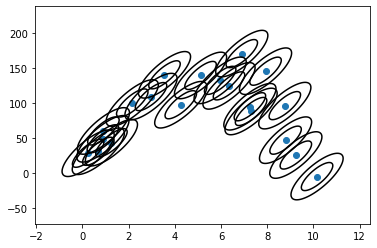

In [8]:
plt.scatter(times_2d,heights_2d)
for i in range(len(times_2d)):
    mu = np.array([times_2d[i],heights_2d[i]])
    cov = covariance_matrix
    Function = generate_experiment_error_function(mu, cov)
    xmin=-3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    xmax=3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    ymin=-3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    ymax=3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    X, Y = numpy.mgrid[xmin:xmax:100j, ymin:ymax:100j] #1000 x 1000 -> 1 million points
    PointsToPlugIn = numpy.vstack([X.ravel(), Y.ravel()])
    PointsToPlugInDataset = PointsToPlugIn.T
    PlugInPointsCount = len(PointsToPlugInDataset)
    FunctionResultValuesForGrid = numpy.zeros((PlugInPointsCount))
    k = 0
    while (k < PlugInPointsCount):
        PointToPlugIn = PointsToPlugInDataset[k]
        FunctionValueForPointToPlugIn = Function(PointToPlugIn)
        FunctionResultValuesForGrid[k] = FunctionValueForPointToPlugIn
        k = k + 1
    Z = numpy.reshape(FunctionResultValuesForGrid, X.shape)
    CS = plt.contour(X, Y, Z, 2,
                             colors='k', # negative contours will be dashed by default
                             )
plt.show()


5.73529792474826e-83
PlugInPointsCount 10000
PointsToPlugInDataset.shape (10000, 2)
PointsToPlugInDataset[0] [ -2. -20.]
Z.shape (100, 100)


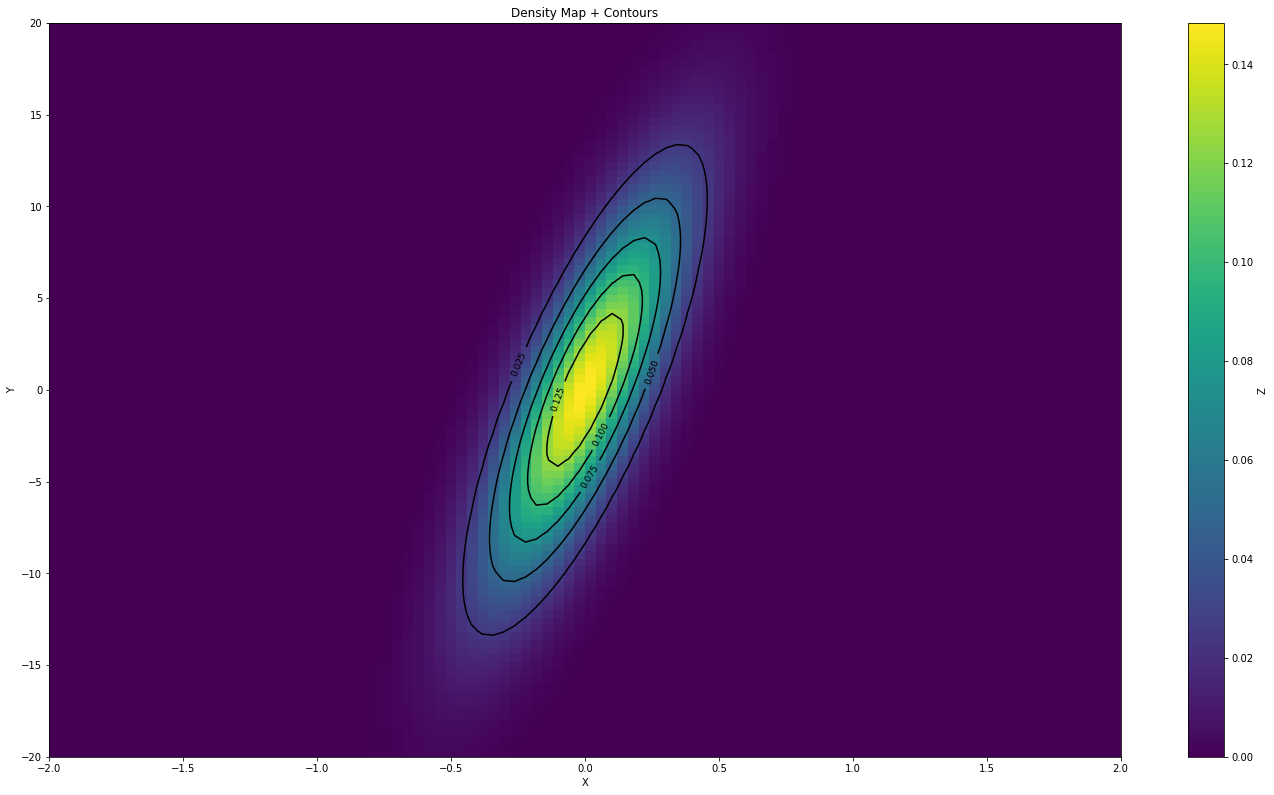

In [255]:


mu = np.array([0,0])
cov = covariance_matrix
experiment_error_function = generate_experiment_error_function(mu, cov)
print ( experiment_error_function( np.array([3,3]) ) )
Library_GraphTwoDimensionDensityColorMap.Main(
    Function = experiment_error_function,
    DomainMinimumPoint  = np.array([-2, -20]),
    DomainMaximumPoint  = np.array([2, 20]),
    ShowContours = True
    )

In [9]:
def bounds_and_priors_to_ppf(bounds,priors=None):
    ppfs={}
    for key, val in six.iteritems(bounds):
        if key in ppfs:
            continue  # ppfs take priority over bounds/priors
        a, b = val
        if priors is not None and key in priors:
            # solve ppf at discrete points and return interpolating
            # function
            x_samples = np.linspace(0., 1., 101)
            ppf_samples = ppf(priors[key], x_samples, a, b)
            f = Interp1D(0., 1., ppf_samples)
        else:
            f = Interp1D(0., 1., np.array([a, b]))
        ppfs[key] = f
    return ppfs

def prior_transform(u):
        d = {}
        for i in range(npdim):
            d[iparam_names[i]] = ppflist[i](u[i])
        v = np.empty(ndim, dtype=np.float)
        for i in range(ndim):
            key = vparam_names[i]
            v[i] = d[key]
        return v

def chisquare(observed_values,expected_values,errors):
    z = (observed_values - expected_values) / errors 
    chi2 = np.sum(z ** 2)
    return(chi2)

def loglike(parameters):
        return -0.5 * chisquare(my_data['height'],
                                my_model(parameters[0],parameters[1],my_data['time']),
                                my_data['error'])
    
def get_marginal_pdfs( vparam_names,weights,samples, bounds,nbins=51, verbose=True ):
    """ Given the results <res> from a nested sampling chain, determine the
    marginalized posterior probability density functions for each of the
    parameters in the model.
    :param res:  the results of a nestlc run
    :param nbins: number of bins (steps along the x axis) for sampling
       each parameter's marginalized posterior probability
    :return: a dict with an entry for each parameter, giving a 2-tuple containing
       NDarrays of length nbins.  The first array in each pair gives the parameter
       value that defines the left edge of each bin along the parameter axis.
       The second array gives the posterior probability density integrated
       across that bin.
    """


    pdfdict = {}
    for param in vparam_names :
        ipar = vparam_names.index( param )
        paramvals = samples[:,ipar]
        
        if nbins>1:
            if param in bounds :
                parvalmin, parvalmax = bounds[param]
            else :
                parvalmin, parvalmax = 0.99*paramvals.min(), 1.01*paramvals.max()
            parambins = np.linspace( parvalmin, parvalmax, nbins, endpoint=True ).flatten()
            binindices = np.digitize( paramvals, parambins )

            # we estimate the marginalized pdf by summing the weights of all points in the bin,
            # where the weight of each point is the prior volume at that point times the
            # likelihood, divided by the total evidence
            pdf = np.array( [ weights[np.where( binindices==ibin )].sum() for ibin in range(len(parambins)) ] )
        else :
            parambins = None
            pdf = None


        mean = (weights  * samples[:,ipar]).sum()
        #print(samples[:,ipar]-mean)
        #print(weights)
        std = np.sqrt( (weights * (samples[:,ipar]-mean)**2 ).sum() )

        pdfdict[param] = (parambins,pdf,mean,std,res.logz)
    return(pdfdict)

def plot_marginal_pdfs(vparam_names,weights,samples, bounds, nbins=101, **kwargs):
    """ plot the results of a classification run
    :return:
    """
    from matplotlib import pyplot as pl
    import numpy as np

    nparam = len(vparam_names)
    # nrow = np.sqrt( nparam )
    # ncol = nparam / nrow + 1
    nrow, ncol = 1, nparam

    pdfdict = get_marginal_pdfs(vparam_names,weights,samples, bounds, nbins)

    fig = plt.gcf()
    for parname in vparam_names :
        iax = vparam_names.index( parname )+1
        ax = fig.add_subplot( nrow, ncol, iax )

        parval, pdf, mean, std, evd = pdfdict[parname]
        ax.plot(  parval, pdf, **kwargs )
        if np.abs(std)>=0.1:
            ax.text( 0.95, 0.95, '%s  %.1f +- %.1f'%( parname, np.round(mean,1), np.round(std,1)),
                     ha='right',va='top',transform=ax.transAxes )
        elif np.abs(std)>=0.01:
            ax.text( 0.95, 0.95, '%s  %.2f +- %.2f'%( parname, np.round(mean,2), np.round(std,2)),
                     ha='right',va='top',transform=ax.transAxes )
        elif np.abs(std)>=0.001:
            ax.text( 0.95, 0.95, '%s  %.3f +- %.3f'%( parname, np.round(mean,3), np.round(std,3)),
                     ha='right',va='top',transform=ax.transAxes )
        else :
            ax.text( 0.95, 0.95, '%s  %.3e +- %.3e'%( parname, mean, std),
                     ha='right',va='top',transform=ax.transAxes )

    plt.draw()

In [10]:
def single_datapoint_likelihood_function(t1,f1,ft,sigma):
    constant=1./np.sqrt(2*np.pi*sigma)
    gauss=constant*np.exp(-(f1-ft)**2./(2.*sigma**2.))
    return(gauss)
    
def multiple_datapoint_likelihood_function(t1s,f1s,fts,sigmas):
    result=1.
    for (t1,f1,ft,sigma) in zip(t1s,f1s,fts,sigmas):
        result*=single_datapoint_likelihood_function(t1,f1,ft,sigma)
        
    return(result)

def single_2d_datapoint_likelihood_function(mu_obs,mu_sample,sigma):
    constant=1./np.sqrt(2*(np.pi**2.)*np.linalg.det(sigma))
    gauss=constant*np.exp(-.5*np.transpose(mu_obs-mu_sample)*np.linalg.inv(sigma)*(mu_obs-mu_sample))
    return(gauss)
    
def multiple_2d_datapoint_likelihood_function(t1s,f1s,sigmas,parameters):
    result=1.
    for (t1,f1,sigma) in zip(t1s,f1s,sigmas):
        sum_2d_gauss=0.
        curve_samples=np.linspace(t1-3*np.sqrt(sigma[0][0]),t1+3*np.sqrt(sigma[0][0]),10)
        for t_sample in curve_samples:
            f_sample=my_model(*np.append(parameters,[t_sample]))
            mu=np.array([t_sample,f_sample])
            x=np.array([t1,f1])
            sum_2d_gauss+=(multi_gauss.pdf(x,mu,sigma)/len(curve_samples))
        
        result*=sum_2d_gauss
    return(result)

def correct_loglikelihood(parameters):
    modeled=np.array([my_model(*np.append(parameters,[x])) for x in my_data['time']])
    observed=my_data['height']
    return(np.log(multiple_2d_datapoint_likelihood_function(my_data['time'],
                                observed,my_model,parameters,covariances)))
    
def correct_2d_loglikelihood(parameters):
    likelihood=np.log(multiple_2d_datapoint_likelihood_function(my_2d_data['time'],
                            my_2d_data['height'],
                            covariance_matrices,parameters))
    
    return(likelihood)
    

/home/developer0/anaconda3/envs/GenericPython3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log
/home/developer0/anaconda3/envs/GenericPython3/lib/python3.7/site-packages/nestle.py:906: RuntimeWarning: invalid value encountered in double_scalars
  math.exp(logz - logz_new) * (h + logz) -


['v', 'g'] [53.3759357  10.34776548]
['v', 'g'] [[14.63041717  4.08792436]
 [ 4.08792436  1.30566873]]


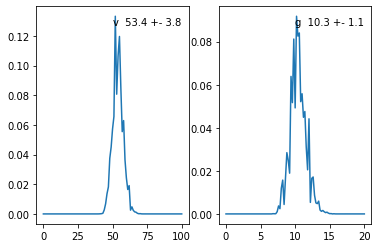

In [11]:
npoints=100
method='single'
maxiter=None
maxcall=None
rstate=None
verbose=False
vparam_names = ['v','g']
bounds={'v':(0,100),'g':(0,20)}
ppfs=bounds_and_priors_to_ppf(bounds)
iparam_names = [key for key in vparam_names if key in ppfs]
ppflist = [ppfs[key] for key in iparam_names]
npdim = len(iparam_names)  # length of u
ndim = len(vparam_names)  # length of v
res = nestle.sample(correct_2d_loglikelihood, prior_transform, ndim, npdim=npdim,
                        npoints=npoints, method=method, maxiter=maxiter,
                        maxcall=maxcall, rstate=rstate,
                        callback=(nestle.print_progress if verbose else None))

vparameters, cov = nestle.mean_and_cov(res.samples, res.weights)
print(vparam_names,vparameters)
print(vparam_names,cov)
plot_marginal_pdfs(vparam_names,res.weights,res.samples,bounds,nbins=101)

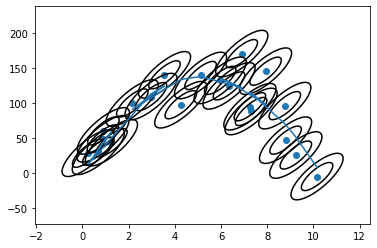

In [12]:
plt.scatter(times_2d,heights_2d)
for i in range(len(times_2d)):
    mu = np.array([times_2d[i],heights_2d[i]])
    cov = covariance_matrix
    Function = generate_experiment_error_function(mu, cov)
    xmin=-3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    xmax=3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    ymin=-3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    ymax=3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    X, Y = numpy.mgrid[xmin:xmax:100j, ymin:ymax:100j] #1000 x 1000 -> 1 million points
    PointsToPlugIn = numpy.vstack([X.ravel(), Y.ravel()])
    PointsToPlugInDataset = PointsToPlugIn.T
    PlugInPointsCount = len(PointsToPlugInDataset)
    FunctionResultValuesForGrid = numpy.zeros((PlugInPointsCount))
    k = 0
    while (k < PlugInPointsCount):
        PointToPlugIn = PointsToPlugInDataset[k]
        FunctionValueForPointToPlugIn = Function(PointToPlugIn)
        FunctionResultValuesForGrid[k] = FunctionValueForPointToPlugIn
        k = k + 1
    Z = numpy.reshape(FunctionResultValuesForGrid, X.shape)
    CS = plt.contour(X, Y, Z, 2,
                             colors='k', # negative contours will be dashed by default
                             )
plt.plot(my_2d_data['time'],my_model(vparameters[0],vparameters[1],
                                  my_2d_data['time']))
plt.show()
